## Импорты & stuff

In [173]:
import random

import numpy as np
import pandas as pd

from scipy import stats
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE, SVMSMOTE, SMOTENC, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

from catboost import CatBoostClassifier, Pool

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
random.seed(42)
np.random.seed(42)

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## EDA

In [9]:
data = pd.read_csv("fraud_data.csv")

In [10]:
data.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3737323,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
264914,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
85647,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
5899326,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
2544263,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


Описание признаков:
- step: represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance before the transaction
- newbalanceOrig: balance after the transaction
- nameDest: recipient of the transaction
- oldbalanceDest: initial balance of recipient before the transaction
- newbalanceDest: the new balance of recipient after the transaction
- **isFraud** (target): fraud transaction

### Basic EDA

In [11]:
# У нас нет пропущенный значений, что радует

data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [12]:
# Посмотрим на количество уникальных сэмплов у каждого признака

for i in data.columns:
    print(f"Column '{i}' values: {data.loc[:, i].nunique()}")

Column 'step' values: 743
Column 'type' values: 5
Column 'amount' values: 5316900
Column 'nameOrig' values: 6353307
Column 'oldbalanceOrg' values: 1845844
Column 'newbalanceOrig' values: 2682586
Column 'nameDest' values: 2722362
Column 'oldbalanceDest' values: 3614697
Column 'newbalanceDest' values: 3555499
Column 'isFraud' values: 2
Column 'isFlaggedFraud' values: 2


In [13]:
# Здесь у нас всё ок
# nameOrig и nameDist это айдишники, поэтому и текстовые
# type тоже текстовый, ибо категориальная переменная
# баланс везде float, что тоже логично
# isFraud тоже ок, ибо бинарный

# step тоже оставим, хоть и не будем работать с ним как с time series, диапазон значений немного странный
# удалим потом, если нужно будет

data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [14]:
# Посмотрим на значения тех признаков, где могли бы быть какие-то ошибки/опечатки,
# которые можно пофиксить руками. Видим, что здесь всё ок.

for i in ["type", "isFraud", "isFlaggedFraud"]:
    print(f"Column '{i}' values: {data.loc[:, i].unique()}")

Column 'type' values: ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
Column 'isFraud' values: [0 1]
Column 'isFlaggedFraud' values: [0 1]


### Checking numerical feature correlation

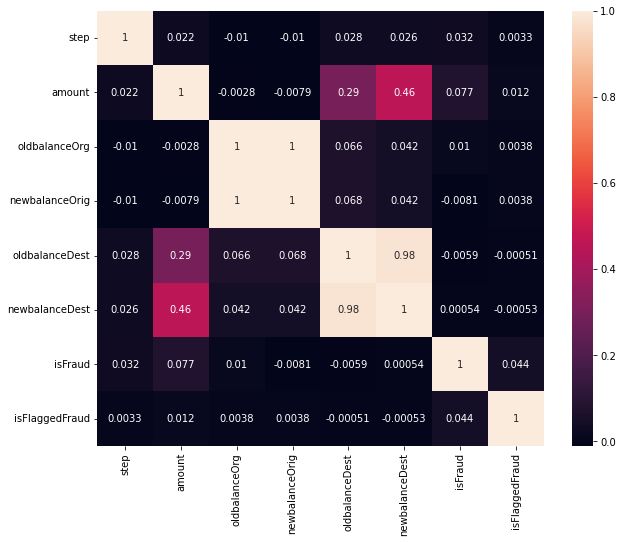

In [15]:
# Посмотрим на корреляцию Пирсона у числовых признаков

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [16]:
# У нас есть признак isFlaggedFraud, который намекает на нечто схожее с целевой переменной,
# но для него нет нормального описания (а мы можем только догадываться), 
# а также он не особо скоррелирован с isFraud, поэтому оставим

# На этой хитмапе видно, что oldBalanceOrg и newBalanceOrg максимально скоррелированы,
# а также oldbalanceDest и newbalanceDest очень скоррелированы
# Но мультиколлинеарность – это плохо, поэтому мы удалим по одному признаку из каждой пары.

In [17]:
data = data.drop(["newbalanceOrig", "newbalanceDest"], axis=1)

### Handling nominal features

In [18]:
# Беглым взглядом на сэмпл датасета и описательную статистику выше
# можно увидеть, что у нас есть:
# - переменные nameOrig и nameDest, которые являются айдишниками

# Поисследуем их тоже

data.head()

,step,type,amount,nameOrig,oldbalanceOrg,nameDest,oldbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,M1979787155,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,M2044282225,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,C553264065,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,C38997010,21182.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,M1230701703,0.0,0,0


In [19]:
data["nameOrig"].value_counts()

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64

In [20]:
data["nameDest"].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: nameDest, Length: 2722362, dtype: int64

In [21]:
# Здесь мы видим, что айдишники повторяются и мы могли бы использовать их при создании моделей
# И мы даже смогли бы выбить метрики побольше даже на тест сете,
# потому что он будет из того же распределения

# Но есть один нюанс: мы же всё-таки не хотим делать нечто игрушечное,
# а хотим сделать нормальную модель, которую не стыдно и на прод выкатить,
# а айдишники это штука специфичная, завтра они могут полностью измениться
# поэтому исключим оба этих столбца для общего блага

In [22]:
data = data.drop(["nameOrig", "nameDest"], axis=1)

### Outlier Detection & Target Variable Analysis

In [23]:
# Ох, как всё плохо...
# Надо что-то делать с имбалансом классов

data["isFraud"].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

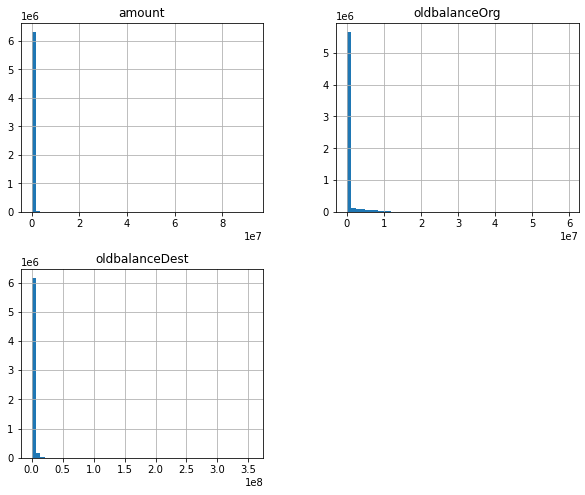

In [24]:
# Что-то подсказывает, что эти хвосты вполне могут быть показателями фрода,
# а не просто выбросами, поэтому мы их пока оставим для дальнейшего анализа

data.loc[:, "amount":"oldbalanceDest"].hist(figsize=(10, 8), bins=50)
plt.show()

<AxesSubplot:>

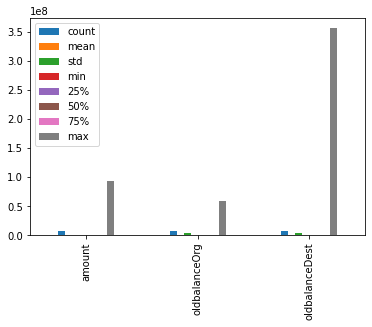

In [25]:
# То же самое здесь, нужно сначала проверить распределение значений у фрода и не-фрода,
# а потом уже думать об удалении

data.loc[:, "amount":"oldbalanceDest"].describe().T.plot(kind="bar")

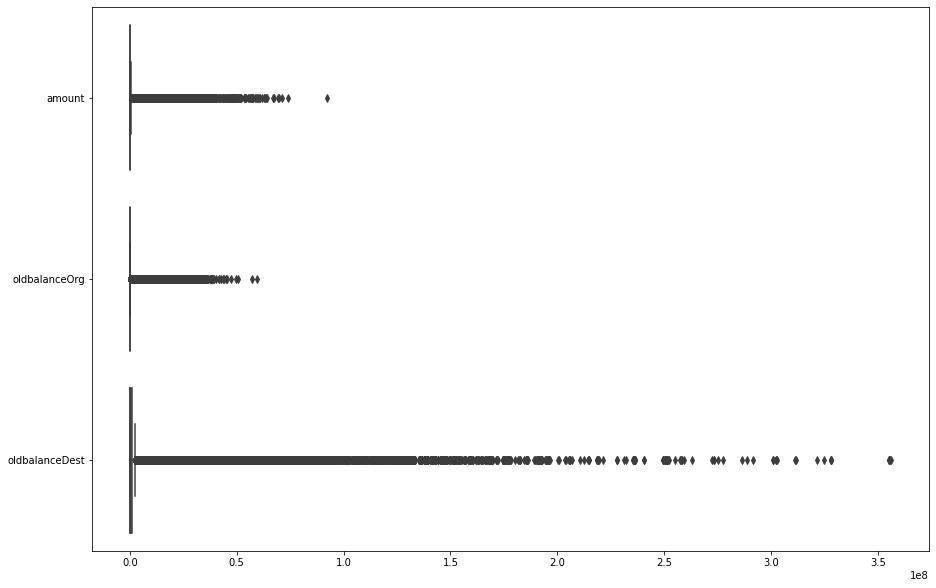

In [26]:
# Ну да, хвосты огромные, посмотрим дальше

plt.figure(figsize=(15, 10))
sns.boxplot(data=data[["amount", "oldbalanceOrg", "oldbalanceDest"]], orient='h')
plt.show()

<AxesSubplot:ylabel='type'>

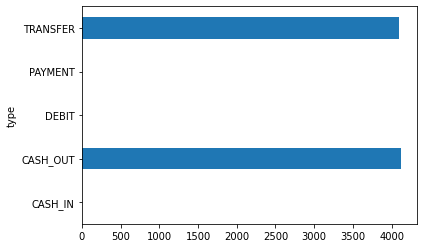

In [27]:
# Так как наш целевой признак бинарный, то мы можем выяснить, в каких типах транзакций чаще всего встречается фрод. 
# Ну, здесь мы чётко видим, что он вообще встречается только в двух типах транзакций

data.groupby("type")['isFraud'].sum().plot(kind="barh")

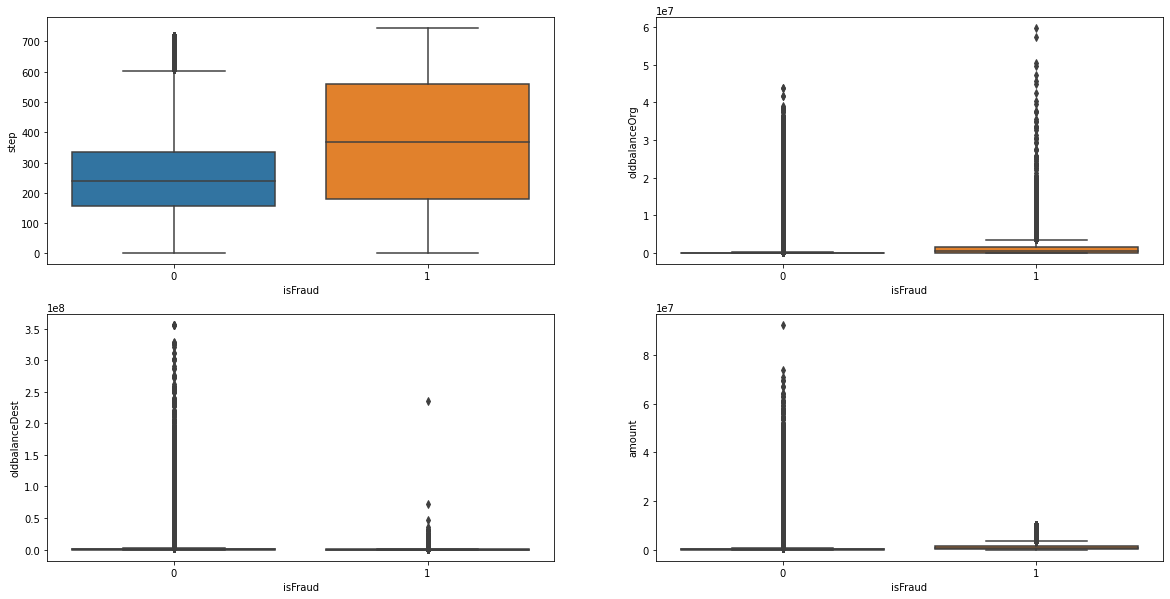

In [28]:
# Посмотрим распределения данных относительно целевого признака
# Здесь мы видим, что распределение значений этих признаков относительно фрода
# достаточно сильно отличается
# да и step не кажется бесполезным, точно оставим

# Мы здесь видим некоторые сэмплы, которые находятся в небольшом отдалении
# даже в достаточно монотонных хвостах
# Мы можем проверить и удалить такие значения, хотя они вряд ли сильно много импакта внесут
# У нас как минимум признак типа транзакции об очень многом говорит для нас и для модели
# Но давайте всё-таки оставим. 
# Если бы мы реально хотели удалять, то фильтрацией по IQR или Z>3 удалили бы неприлично много
# Давайте даже посмотрим на это количество

rel_cols = ["step", "oldbalanceOrg", "oldbalanceDest", "amount"]

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for ax, col in zip(axes, rel_cols):
    sns.boxplot(ax=ax, data=data, x="isFraud", y=col)

In [29]:
# Да, удалили бы почти 350к, но тут это необязательно выбросы, а скорее специфика датасета.
# Логрегу с линейной апрроксимацией всё равно будет плохо с таким хвостами,
# даже если мы удалим всё после третьей сигмы, так что пусть у нас метрики здесь и станут (мб) на пару пунктов ниже
# из-за достаточно однозначного распределения в нужный класс некоторых экстремальных значений. 
# Но не станем забывать, что у нас трейн и тест из одного распределения и генерализуемости ради всё-таки уберём их.


z = np.abs(stats.zscore(data[rel_cols]))
outliers = np.where(z > 3)

print(outliers[1].shape)

(346551,)


In [30]:
# Убираем
data = data.drop(outliers[0]).reset_index(drop=True)

## Let the (imbalanced) game begin!

In [26]:
# Как мы видели ранее, у нас огромный перекос в сторону не-фрода,
# что абсолютно ок и специфично этой задаче

# Примением способы балансировки классов и посмотрим, что выйдет.
# Я мог бы использовать классический SMOTE (+ random undersampling), но
# - с андерсэмплингом нужно быть осторожным, можно удалить важное
# - в наших данных есть огромные хвосты и диапазоны значений двух классов частенько пересекаются
# - даже в этих хвостах есть нечто похожее на выбросы

# Таким образом, нам лучше использовать более новый и оптимальный метод ADASYN,
# который менее подвержен искажению данных из-за выбросов, а также
# может значительно лучше расширить недопредставленную в датасете выборку с фродом
# путём учета плотности распределения классов и синтеза только таких искусственных сэмплов,
# которые (скорее всего) будут более репрезентативны по сравнению с сэмплами, которые бы создал классический SMOTE.

# Ну и мы можем что-то интересное ещё найти в новых данных
# Ах да, кажется я снова превращаю лабу по классификации в лабу по EDA. Не, ну а что плохого-то?))

### Data Preprocessing

In [31]:
# Произведём базовый препроцессинг и отложим отдельную версию для бустингов

data_res = data.copy()

In [32]:
scaler = StandardScaler()
sampler = ADASYN()

In [33]:
# Нормализуем только real-valued признаки и не будем трогать бинарные,
# потому что нормализация бинарных признаков не имеет буквально никакого смысла,
# это ведь не скаляры, а boolean значения..

# Да и стандартизуем мы в том числе для того, чтобы в градиентах не было бунтов и всё проходило спокойно,
# а у нас тут и так всё ок, поэтому оставим

# Будем энкодить категориальную переменную через OrdinalEncoder, 
# хотя у нас не так много уникальных значений и мы могли бы использовать и OneHotEncoder
# но мы дальше будем деревья использовать, а они не очень любят sparse данные,
# но у нас ведь не только деревья, а некоторые другие алгоритмы любят неверно интерпретировать
# такие категориальные переменные как ordinal данные... :)
# В любом случае, вряд ли это значительно скажется на результате, так что не будем раздувать размерности

data["type"] = data["type"].astype("category")
data["type"] = data["type"].cat.codes

rel_cols = ["step", "amount", "oldbalanceOrg", "oldbalanceDest"]
X, y = data.drop(["isFraud"], axis=1), data["isFraud"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [35]:
X_train.loc[:, rel_cols] = scaler.fit_transform(X_train.loc[:, rel_cols])
X_test.loc[:, rel_cols] = scaler.transform(X_test.loc[:, rel_cols])

In [36]:
# классы до балансировки

np.unique(y_train, return_counts=True)

(array([0, 1]), array([4818450,    4685]))

In [37]:
X_train, y_train = sampler.fit_resample(X_train, y_train)

In [38]:
# Сначала поделим всё на трейн-тест, а уж потом примением ADASYN,
# но ТОЛЬКО НА ТРЕЙН, а в ином случае мы всё сломаем на этапе подсчёта метрик

# Я мог бы всё оценить на K-fold CV, но датасет большой, а я не хочу ждать до конца времён,
# поэтому обойдемся дефолтным stratified 80/20 (данных достаточно много)

In [39]:
# Ура, сбалансировали классы

np.unique(y_train, return_counts=True)

(array([0, 1]), array([4818450, 4818552]))

In [40]:
# А знаете что?

# Мы проводили корреляционный анализ на очень несбалансированных данных,
# которых ещё и совсем мало было, из-за чего мы могли не видеть каких-то корреляций явных

# Но теперь мы сделали данные (вероятнее всего) значительно более адекватными,
# а что это значит? А это значит, что пора смотреть это снова))

# И (((извините, но я должен вставить это)))

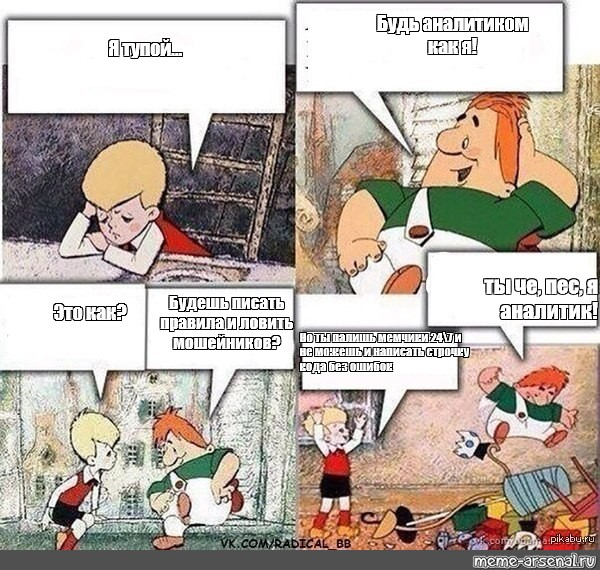

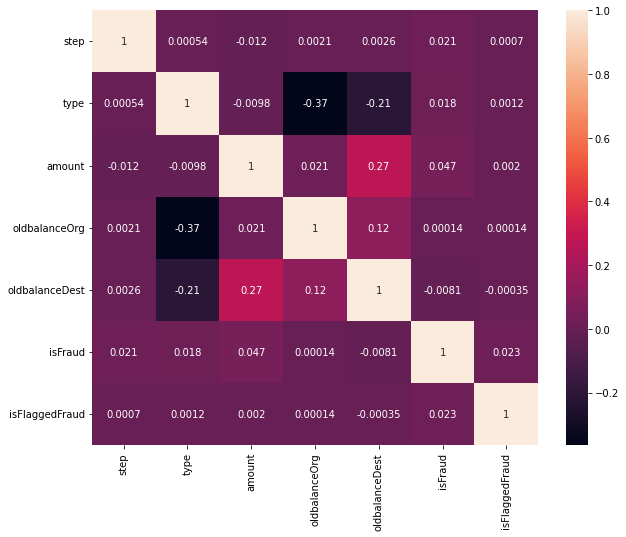

In [41]:
# Продолжим и рассмотрим корреляции снова
# Картина немного изменилась, но не сильно, сильно скоррелированных не появилось
# (хотя иногда так бывает)

# Иные распределения уж смотреть не будем, поверим алгоритму на слово (но только в этот раз!)

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(method="pearson"), annot=True)
plt.show()

### Casual Model Time

In [42]:
# фром эс-ка-лёрн точка лайниар модел импорт лоджистик регрешн... oh wait
# Ладно, обучим всё с дефолтными параметрами пока

In [98]:
logreg = LogisticRegression(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
rf = RandomForestClassifier(n_jobs=-1, verbose=1)

In [44]:
# Вообще, я тестил логрег и без балансировки, но там ситуация была совершенно иная.
# Там нулевой класс предсказывался идеально, а в первом была относительно неплохая точность, но очень низкая полнота.
# Мы посмотрим ещё на другие модели, но здесь видно, что распределение плохое поддаётся линейной аппроксимации

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F-Score:", f1_score(y_test, y_pred))

print("\n")
print(classification_report(y_test, y_pred))

Precision: 0.0023116636272570825
Recall: 0.7685738684884714
F-Score: 0.004609463228007098


              precision    recall  f1-score   support

           0       1.00      0.68      0.81   1204613
           1       0.00      0.77      0.00      1171

    accuracy                           0.68   1205784
   macro avg       0.50      0.72      0.41   1205784
weighted avg       1.00      0.68      0.81   1205784



In [99]:
# Здесь уже значительно лучше, чем у логрега: нулевой класс распознаётся идеально, а первый значительно лучше в любом случае
# И этот результат выше, чем был бы без сэмплирования

# И как мне кажется, в задаче определения фрода нам важнее заблокировать не-фрод транзакцию, но потом её ещё раз перепроверить,
# чем пропустить фрод-транзакцию, так что здесь высокая полнота даже с относительно низкой точностью имеет право на жизнь.

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F-Score:", f1_score(y_test, y_pred))

print("\n")
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    1.0s finished


Precision: 0.46562067374250116
Recall: 0.8616567036720751
F-Score: 0.6045536249251049


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1204613
           1       0.47      0.86      0.60      1171

    accuracy                           1.00   1205784
   macro avg       0.73      0.93      0.80   1205784
weighted avg       1.00      1.00      1.00   1205784



In [46]:
# Ну KNN с нулевые классом справился хорошо, с первым лучше, чем логрег,
# но прилично хуже, чем Random Forest. Точность в 0.13 класса это уж слишком мало, его мы дальше рассматривать не будем

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F-Score:", f1_score(y_test, y_pred))

print("\n")
print(classification_report(y_test, y_pred))

Precision: 0.1282760629004077
Recall: 0.7523484201537147
F-Score: 0.21918149023510386


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1204613
           1       0.13      0.75      0.22      1171

    accuracy                           0.99   1205784
   macro avg       0.56      0.87      0.61   1205784
weighted avg       1.00      0.99      1.00   1205784



In [47]:
# Некоторые выводы:
# - Логрег не может нормально аппроксимировать наши данные
# - KNN (default k=5) справляется с этим чуть лучше, но значительно проигрывает Random Forest
# Random Forest показал себя лучше всех
# - Результат не лучший, но полнота в 0.86 вполне себе на уровне, а ложно положительные блокировки нормальных транзакций можно и перепроверить,
# - всё лучше, чем пропускать много фрода, как модели без балансировки

In [48]:
# Здесь мы видим, что самыми важными признаками являются amount (сумма транзакции) и oldbalanceOrg (баланс счёта, с которого была проведена транзакция)
# Чуть менее (но тоже важным) оказался тип транзакции
# В первом и третьем случаях случае прямая корреляция, во втором обратная

logreg_feats = pd.DataFrame({"feature_name": X_train.columns, "importance_coef": logreg.coef_.squeeze()})
logreg_feats.sort_values(by="importance_coef", ascending=False)

,feature_name,importance_coef
2,amount,0.492400
0,step,0.377959
1,type,0.169131
5,isFlaggedFraud,0.000003
4,oldbalanceDest,-0.209466
3,oldbalanceOrg,-0.409037


In [49]:
# Здесь топ-3 важных признаков тот же, но чуть в ином порядке, но в целом всё ок

rf_feats = pd.DataFrame({"feature_name": X_train.columns, "importance_coef": rf.feature_importances_.squeeze()})
rf_feats["importance_coef"] = rf_feats["importance_coef"].round(3)
rf_feats.sort_values(by="importance_coef", ascending=False)

,feature_name,importance_coef
3,oldbalanceOrg,0.358
1,type,0.281
2,amount,0.193
0,step,0.090
4,oldbalanceDest,0.078
5,isFlaggedFraud,0.000


## Hyperparameter Tuning

In [50]:
# Потюним Random Forest ещё немного, но возьмём Random Forest и небольшой search space (только сейчас, но обычно пусть лучше он будет большим, а поиск байесовским)
# Подбор гиперпараметров будем осуществлять на кросс-валидации, поэтому нам сэмплирование нужно упаковать в пайплайн и применять на исходных данных в трейне
# Дропнем столбец isFlaggedFraud из-за отсутствия пользы

In [51]:
data = data_res.copy()

In [52]:
data["type"] = data["type"].astype("category")
data["type"] = data["type"].cat.codes

data = data.drop("isFlaggedFraud", axis=1)

rel_cols = ["step", "amount", "oldbalanceOrg", "oldbalanceDest"]
X, y = data.drop(["isFraud"], axis=1), data["isFraud"]

In [153]:
# Сначала я был полон энтузиазма и хотел подобрать параметры для Random Forest,
# ибо он здесь перформит лучше всего...

# Но у меня датасет после оверсэмплинга содержит >10кк сэмплов и обучается вечность,
# что уж говорить о подборе гиперпараметров

# Так, после 6 часов периодических взглядов на дашборд htop почти без логов
# в надежде, что оно не упало, я принял волевое решение просто взять и подобрать
# параметры для логрега, это хоть что-то)))

logreg = LogisticRegression(n_jobs=-1, solver="saga", max_iter=10000)

scaler_pipeline = ColumnTransformer(
        remainder="passthrough",
        transformers=[("scaler", scaler, rel_cols)]
)

balancer_pipeline = Pipeline(steps=[("adasyn", sampler), ("lr_model", logreg)])

pipeline = Pipeline(steps=[("scaler", scaler_pipeline), ("balancer", balancer_pipeline)])

cv = StratifiedKFold(n_splits=3)

In [156]:
params = {
    "balancer__lr_model__penalty": ["l1", "l2", "elasticnet"],
    "balancer__lr_model__C": [10e-3, 10e-2, 1, 10]
}

In [157]:
random_search_clf = RandomizedSearchCV(
    pipeline, 
    params, 
    scoring=["precision", "recall", "f1", "balanced_accuracy", "roc_auc"], 
    refit="balanced_accuracy",
    verbose=1,
    n_jobs=-1, 
    cv=3, 
    n_iter=5,
)

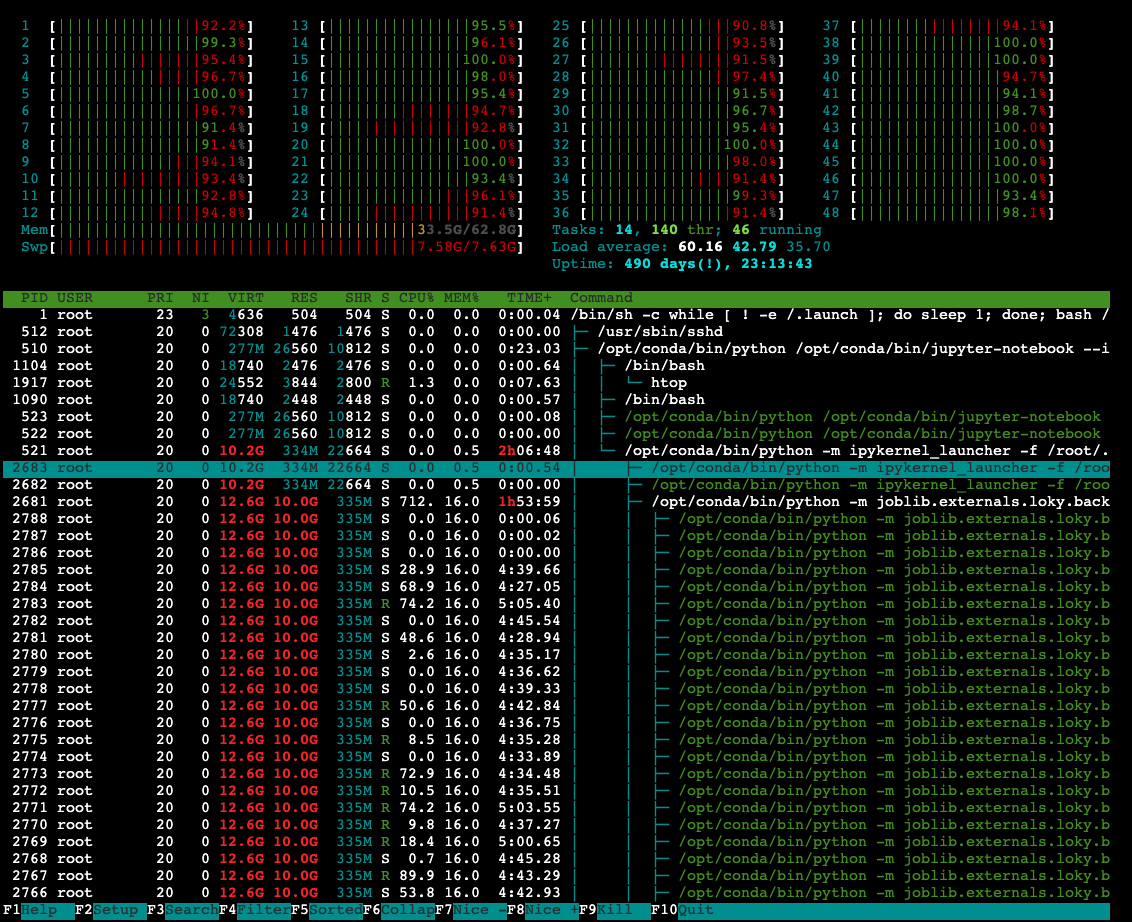

In [159]:
# Подберём параметры
search_results = random_search_clf.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [160]:
# Параметры лучшей модели
search_results.best_params_

{'balancer__lr_model__penalty': 'l2', 'balancer__lr_model__C': 0.1}

In [163]:
# Метрика balanced_accuracy лучшей модели
search_results.best_score_

0.722299558827562

### Boosting Time

In [162]:
# Пойдём простым путём, не будем экспериментировать с категориальными переменными и остальными предобработками
# Поэтому возьмём простой человеческий CatBoost и зафиттим на наших данных без оверсэмплинга, НО с увеличением веса положительного класса примерно в 1000 раз

In [174]:
data = data_res.copy()

In [220]:
X, y = data.drop(["isFraud"], axis=1), data["isFraud"]

In [213]:
print(y.value_counts(normalize=True))
print()
print(0.999029 / 0.000971)

0    0.999029
1    0.000971
Name: isFraud, dtype: float64

1028.8661174047375


In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [177]:
train_pool = Pool(data=X_train, label=y_train, cat_features=["type"])
test_pool = Pool(data=X_test, label=y_test, cat_features=["type"])

In [234]:
model_cb = CatBoostClassifier(
    eval_metric="Precision", 
    custom_metric=["Precision", "Recall", "F1", "BalancedAccuracy"],
#     scale_pos_weight=1028,  # ~same
    auto_class_weights="Balanced",  # ~same
    task_type="GPU"
)

In [209]:
model_cb.fit(
    train_pool, 
    eval_set=test_pool, 
    plot=True, 
    verbose=25,
    use_best_model=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.034629


Default metric period is 5 because BalancedAccuracy is/are not implemented for GPU
Metric BalancedAccuracy is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric BalancedAccuracy is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.8822880	test: 0.8826667	best: 0.8826667 (0)	total: 122ms	remaining: 2m 2s
25:	learn: 0.9628753	test: 0.9627619	best: 0.9640097 (20)	total: 1.71s	remaining: 1m 4s
50:	learn: 0.9663135	test: 0.9662068	best: 0.9662068 (50)	total: 3.28s	remaining: 1m 1s
75:	learn: 0.9735347	test: 0.9735383	best: 0.9735383 (75)	total: 4.83s	remaining: 58.7s
100:	learn: 0.9755551	test: 0.9755494	best: 0.9756212 (90)	total: 6.37s	remaining: 56.7s
125:	learn: 0.9766512	test: 0.9766270	best: 0.9766270 (125)	total: 7.91s	remaining: 54.9s
150:	learn: 0.9777838	test: 0.9777374	best: 0.9777374 (150)	total: 9.47s	remaining: 53.3s
175:	learn: 0.9787936	test: 0.9786853	best: 0.9786853 (175)	total: 11s	remaining: 51.7s
200:	learn: 0.9800335	test: 0.9798851	best: 0.9798851 (200)	total: 12.6s	remaining: 50.1s
225:	learn: 0.9807455	test: 0.9805998	best: 0.9805998 (225)	total: 14.2s	remaining: 48.5s
250:	learn: 0.9815931	test: 0.9814838	best: 0.9814838 (250)	total: 15.7s	remaining: 46.9s
275:	learn: 0.9828882	t

In [210]:
# В целом, важные категории те же

cb_feats = pd.DataFrame({"feature_name": X_train.columns, "importance_coef": model_cb.feature_importances_.squeeze()})
cb_feats["importance_coef"] = cb_feats["importance_coef"].round(3)
cb_feats.sort_values(by="importance_coef", ascending=False)

,feature_name,importance_coef
3,oldbalanceOrg,37.579
2,amount,31.329
1,type,17.535
4,oldbalanceDest,8.494
0,step,5.064
5,isFlaggedFraud,0.000


In [211]:
# Recall у этих моделей лучший среди всех
# Насчёт Precision всё и так понятно

{k: np.mean(v) for k, v in model_cb.evals_result_["validation"].items()}

{'Precision': 0.9844031420563457,
 'Precision:use_weights=false': 0.07170938712168458,
 'Recall:use_weights=false': 0.9942303852216289,
 'Logloss': 0.04762790353756779,
 'BalancedAccuracy:use_weights=true': 0.9893986807951846,
 'Precision:use_weights=true': 0.9844031420563457,
 'Recall:use_weights=true': 0.9942303852216289,
 'BalancedAccuracy:use_weights=false': 0.9893986807951846,
 'F1:use_weights=false': 0.13274159527250254,
 'F1:use_weights=true': 0.9892614802471649}

# That's All, Folks!